In [1]:
annotations_dir = 'annotations'
images_dir = 'images'
dataset_dir = 'dataset'

## Download data

In [2]:
# from google.colab import files
# files.upload()

In [3]:
# # face Mask Detection with two classes
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/kaggle.json
# !chmod 600 /root/.kaggle/kaggle.json
# !kaggle datasets download andrewmvd/face-mask-detection
# !unzip face-mask-detection.zip

## Preprocessing

In [20]:
import xml.etree.ElementTree as ET
from tqdm import tqdm
import glob
import cv2
import os

In [21]:
os.makedirs(dataset_dir, exist_ok = True)
labels = ['without_mask', 'with_mask', 'mask_weared_incorrect']
[os.makedirs(os.path.join(dataset_dir, label), exist_ok = True) for label in labels]
labels = labels[:2]

In [6]:
def save_imgs_from_annotations(annotation_path, img_path, pad_area = (0,0), save_dir = ''):
  """Gets the list of images and labels from annotation file and image

  Args:
    annotation_path (str): annotation path
    img_path (str): image path
    pad_area (tuple, list): additional area to enlarge cut images, default is (0, 0)
    save_dir (str):  save dictionary where the cut frames will be saved

  Returns:
    tuple: two lists with images and labels respectively
  """
  tree = ET.parse(annotation_path)
  root = tree.getroot()
  filename, _ = os.path.splitext(os.path.basename(annotation_path))
  area_width, area_height = pad_area

  # Read image
  img = cv2.imread(img_path)
  height, width = img.shape[:2]
  img_type = os.path.splitext(img_path)[1]
  # Cut specific frames using annotation bounding boxes
  for i, box in enumerate(root.findall("object")):
    # Define label
    label = box.find('name').text
    # Define coords
    bndbox = box.find('bndbox')
    xmin, ymin = int(bndbox.findtext('xmin')), int(bndbox.findtext('ymin'))
    xmin, ymin = max(xmin - area_width, 0), max(ymin - area_height, 0)
    xmax, ymax = int(bndbox.findtext('xmax')), int(bndbox.findtext('ymax'))
    xmax, ymax = min(xmax + area_width, width), min(ymax + area_height, height)
    cut_img = img[ymin:ymax, xmin:xmax]
    # Save the image into specific dictionary corresponding the label
    save_path = os.path.join(save_dir, label, filename + '_-_' + str(i) + img_type)
    if not cv2.imwrite(save_path, cut_img):
      raise OSError(f"The function could not save the image {save_path}")

In [7]:
def preprocess_dataset(annotations_dir, images_dir, img_type = '.png', **kwargs):
  """Prepocess dataset using annotation bounding boxes"""

  annotations = glob.glob(os.path.join(annotations_dir, '*.xml'))
  for annotation_path in tqdm(annotations):
    filename = os.path.splitext(os.path.basename(annotation_path))[0]
    img_path = os.path.join(images_dir, filename + img_type)
    save_imgs_from_annotations(annotation_path, img_path, **kwargs)

In [8]:
preprocess_dataset(annotations_dir, images_dir, save_dir = dataset_dir)

  0%|          | 0/853 [00:00<?, ?it/s]

100%|██████████| 853/853 [00:17<00:00, 49.17it/s]


## Train model

In [22]:
import shutil

shutil.rmtree(os.path.join(dataset_dir, 'mask_weared_incorrect'))

In [23]:
cnt = {label: len(os.listdir(os.path.join(dataset_dir, label))) for label in labels}
cnt

{'without_mask': 717, 'with_mask': 3232}

In [11]:
!pip install tensorflow-addons

In [12]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os

c:\Users\georg\Projects\class-activation-map\venv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\georg\Projects\class-activation-map\venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.10.0 and strictly below 2.13.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.3 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, 

## Creating datasets

In [33]:
from tensorflow.keras.utils import image_dataset_from_directory

# 0 - without mask
# 1 - mask

input_shape = (32, 32, 3)
train_ds = image_dataset_from_directory(
    dataset_dir,
    batch_size = None,
    class_names = labels,
    image_size = input_shape[:2],
    seed = 1,
    validation_split = 0.3,
    # subset = 'both'
    subset = 'training'
    )

val_ds = image_dataset_from_directory(
    dataset_dir,
    batch_size = None,
    class_names = labels,
    image_size = input_shape[:2],
    seed = 1,
    validation_split = 0.3,
    # subset = 'both'
    subset = 'validation'
    )

Found 3949 files belonging to 2 classes.
Using 2765 files for training.
Found 3949 files belonging to 2 classes.
Using 1184 files for validation.


## Train model

In [37]:
rescale = tf.keras.layers.Rescaling(1/255.)
aug = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])
input = layers.Input(input_shape)
rescale_output = rescale(input)
aug_output = aug(rescale_output)

# base_model = tf.keras.applications.MobileNetV2(input_shape, include_top=False)
base_model = tf.keras.applications.VGG16(include_top=False)
# base_model.trainable = False
trainable_value = True
for layer in base_model.layers[::-1]:
  if layer.name!='block5_conv1':
    layer.trainable = trainable_value
  else:
    trainable_value = False

# inputs = base_model.inputs
# outputs = base_model.output
output = base_model(aug_output)
output = layers.GlobalAveragePooling2D()(output)
output = layers.Dense(128, activation = 'relu')(output)
output = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(output)

In [38]:
test_model = models.Model(inputs=input, outputs=output, name = 'tripletloss_model')

In [39]:
test_model.summary()

Model: "tripletloss_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                 

In [40]:
test_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tfa.losses.TripletHardLoss(0.2))

In [41]:
model_name = test_model.name
# model_name = 'tripletloss_model'
best_w = tf.keras.callbacks.ModelCheckpoint(
    f'{model_name}_best.hdf5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='min'
    )

last_w = tf.keras.callbacks.ModelCheckpoint(
    f'{model_name}_last.hdf5',
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode='auto'
    )

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, mode = 'min')

callbacks = [best_w, last_w, early_stopping]

In [ ]:
epochs = 1_000
history = test_model.fit(
    train_ds.batch(1024),
    epochs=epochs,
    validation_data=val_ds.batch(128),
    callbacks = callbacks,
    # class_weight = class_weight
    )

## Plot

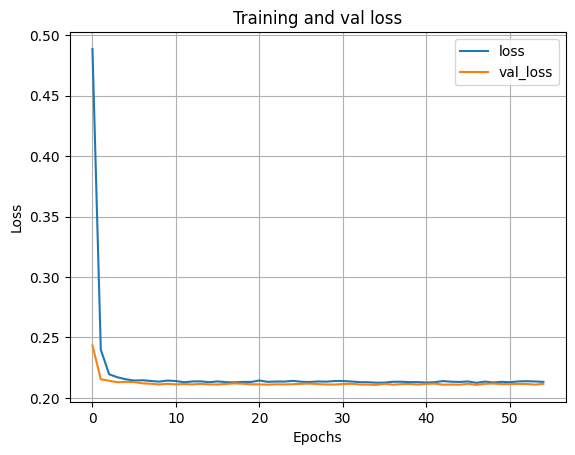

In [43]:
epochs_range = history.epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(epochs_range, loss,label = 'loss')
plt.plot(epochs_range, val_loss,label = 'val_loss')
plt.title('Training and val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()


## Test model

In [14]:
test_model = tf.keras.models.load_model('tripletloss_model_best.hdf5', compile = False)

In [45]:
# for val_batch in val_ds.unbatch().batch(val_nb):
for val_batch in val_ds.batch(1184):
  break
val_batch[0].shape

TensorShape([1184, 32, 32, 3])

In [46]:
# for train_batch in train_ds.batch(train_nb):
for train_batch in train_ds.batch(2765):
  break
train_batch[0].shape

TensorShape([2765, 32, 32, 3])

In [47]:
def k_nearest(x, images,labels,model, k=5):
  """k nearest function

  Args:
    x (tf.Tensor): batch for which predictions should be defined
    images: images for k nearest algorithm
    labels: labels of given images
    model: tensorflow model for predictions
    k: number of neighbours

  Returns:
    tf.Tensor: batch of predictions
  """
  preds = model.predict(images)
  y = model.predict(x)
  subtraction = (tf.expand_dims(y, 1) - preds)
  confidence = 1/(tf.norm(subtraction, axis = -1) + 1e-7)
  sorted_indices = tf.argsort(confidence,direction='DESCENDING')
  sorted_labels = tf.gather_nd(labels, tf.expand_dims(sorted_indices, -1))
  sorted_count = tf.math.bincount(sorted_labels[:,:k], axis = -1)
  result = tf.argmax(sorted_count, axis = -1)
  return result

In [48]:
y_pred = k_nearest(val_batch[0], train_batch[0], train_batch[1], test_model, k=3)
y_val = val_batch[1]

37/37 [==============================] - 0s 5ms/step


In [49]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

accuracy_score(y_val, y_pred), precision_score(y_val, y_pred), recall_score(y_val, y_pred)

(0.9510135135135135, 0.9650205761316872, 0.975051975051975)

## Plot the image with preds

Label: tf.Tensor(1, shape=(), dtype=int32)
Prediction: tf.Tensor(1, shape=(), dtype=int64)


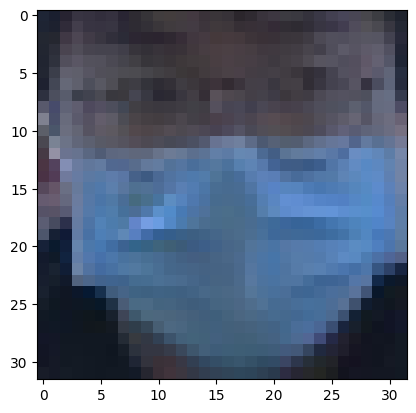

In [181]:
i = np.random.randint(0, val_batch[0].shape[0])
print('Label:', y_val[i])
print('Prediction:', y_pred[i])
plt.imshow(val_batch[0][i]/255.)